# CNN with SAM
M. Busaleh, M. Hussain, H. A. Aboalsamh, Fazal-e-Amin, and S. A. Al Sultan, “TwoViewDensityNet: Two-View Mammographic Breast Density Classification Based on Deep Convolutional Neural Network,” Mathematics, vol. 10, no. 23, p. 4610, Dec. 2022, doi: 10.3390/math10234610.

# Viewer 


## Observations

1. Images were transformed to 8-bit gray.
2. Preprocessing does  wrong its job in some the images below

A_1708_1.LEFT_MLO.tif

A_1500_1.LEFT.MLO.tif

A_1980_1.LEFT_CC.tif

B_3608.LEFT_MLO.tif

B3490_1.RIGHT_MLO.tif

A_1701_RIGHT.RIGHT_CC.tf

A_1425_1_RIGHT_MLO.tif

# Model

## Architecture

In [7]:
! pip install -U tensorflow

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/ba/7c/b971f2485155917ecdcebb210e021e36a6b65457394590be01cc61515310/tensorflow-2.13.0-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/40/fa/98115f6fe4d92e1962f549917be2dc8e369853b7e404191996fedaaf4dd6/tensorflow_intel-2.13.0-cp310-cp310-win_amd64.whl.metadata
     --------------------------------------- 14.8/14.8 MB 14.2 MB/s eta 0:00:00
  Obtaining dependency information for protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3 from https://files.pythonhosted.org/packages/5e/46/5b9674a33cbf690ffdd79ab1863767a66461cd06ea7aeb9f90e4e50be7a5/protobuf-4.24.3-cp310-abi3-win_amd64.whl.metadata
  Using cached protobuf-4.24.3-cp310-abi3-win_amd64.whl.metadata (540 bytes)
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
     ---------------------------------------- 5

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\uabc_\\AppData\\Local\\Temp\\pip-uninstall-zod3wtkt\\internal\\_api_implementation.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [1]:
import tensorflow as tf;
print(tf.reduce_sum(tf.random.normal([1000, 1000])))

ImportError: Traceback (most recent call last):
  File "C:\Users\uabc_\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input

ImportError: Traceback (most recent call last):
  File "C:\Users\uabc_\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import numpy as np
from focal_loss import SparseCategoricalFocalLoss

K = 4 # number of classses
N = 32 # number of training instances in a batch.
shape = (336, 224, 3)

# y_true has the shape (batch_size, d0, ... dN)
# y_pred has the shape (batch_size, d0, .. dN)
# Example
# y_true = [0, 1, 2]
# y_pred = [[0.8, 0.1, 0.1], [0.2, 0.7, 0.1], [0.2, 0.2, 0.6]]
def sparse_categorical_weighted_cross_entropy_loss(y_true, y_pred):
    # calculate_class_weights
    y, _, count = tf.unique_with_counts(y_true[:,0])
    label_space = tf.constant(y_pred.shape[1])
    output = tf.zeros(label_space, dtype=count.dtype)
    output = tf.tensor_scatter_nd_update(output, tf.expand_dims(y, axis=1)-1, count)
    class_weights_tensor =  tf.cast(output/len(y_true), dtype=tf.float64)
    # 10^i <= y_{ni} <= 1-10^i
    y_pred = tf.cast(tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7), dtype=tf.float64)
    y_true = tf.cast(y_true, dtype=tf.float64)
    return -tf.reduce_sum(class_weights_tensor * y_true * tf.math.log(y_pred), axis=-1)/len(y_true)

def sparse_categorical_weighted_cross_entropy_loss_with_logits(y_true, y_pred):
  y_true_one_hot = tf.one_hot(y_true[:,0], 5)
  sparse_ce = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true_one_hot, logits=y_pred)
  return sparse_ce

# f = SparseCategoricalCrossentropy(from_logits=False,reduction=tf.keras.losses.Reduction.NONE)
# f = SparseCategoricalFocalLoss(gamma=0.25,reduction=tf.keras.losses.Reduction.NONE)
# loss_fn = sparse_categorical_weighted_cross_entropy_loss
# f = tf.keras.losses.mean_squared_error

def load(path):
    with open(f"mammograms_npy\\{path}.npy", 'rb') as file:
        return tf.convert_to_tensor(np.load(file)*1./255)

def generate_from_df(index):
  for (index,instance) in df.iloc[index].iterrows():
    yield (load(instance['minio_path'][0]),load(instance['minio_path'][1])), instance['breast_density'][0]

def generate_dataset_from_index(index):
    return tf.data.Dataset.from_generator(
       generate_from_df, 
       args=[index],
       output_signature=(
         (tf.TensorSpec(shape=shape, dtype=tf.int32),
         tf.TensorSpec(shape=shape, dtype=tf.int32)),
         tf.TensorSpec(shape=(), dtype=tf.int32),
        )
      ).batch(32)

def create_model(loss_fn):
    """
    The model below is a ResNet-50 pretrained on ImageNet [27];
    its architecture is based on residual learning, which allows increasing the depth of a CNN
    model that prevents the problem of gradient vanishing [31] and degradation [32,33].
    Text from Paper.
    """
    res_net1 = ResNet50(weights='imagenet', include_top=False, input_shape=shape)
    res_net2 = ResNet50(weights='imagenet', include_top=False, input_shape=shape)

    base_model1 = Model(res_net1.input, res_net1.output, name='ResNet50_View1')
    base_model2 = Model(res_net2.input, res_net2.output, name='ResNet50_View2')

    for layer in base_model1.layers:
        layer.trainable = False

    for layer in base_model2.layers:
        layer.trainable = False

    input1 = Input(shape=shape)
    input2 = Input(shape=shape)

    features1 = base_model1(input1)
    features2 = base_model2(input2)

    flattened_features1 = Flatten()(features1)
    flattened_features2 = Flatten()(features2)

    """
    In our proposed method, the features from the two views are fused by the concatenation layer.
    Text from Paper.
    """
    concatenated = tf.keras.layers.concatenate([flattened_features1, flattened_features2])

    """
    The last layer of the model is the classification layer; it is a fully connected layer with
    four output neurons to classify the input views into one of the four breast density categories;
    each neuron represents a different BI-RADS class.

    SoftMax converts the numerical output of a convolutional neural network to class-specific probability values.
    """
    output = Dense(K, activation='softmax')(concatenated)

    model = Model(inputs=[input1, input2], outputs=output)

    optimizer = tf.keras.optimizers.SGD(learning_rate=10**-4, momentum=0.9)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
    
    return model


model = create_model(tf.keras.losses.mean_squared_error)
model.summary()

ImportError: Traceback (most recent call last):
  File "C:\Users\uabc_\anaconda3\lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 62, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: The specified module could not be found.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

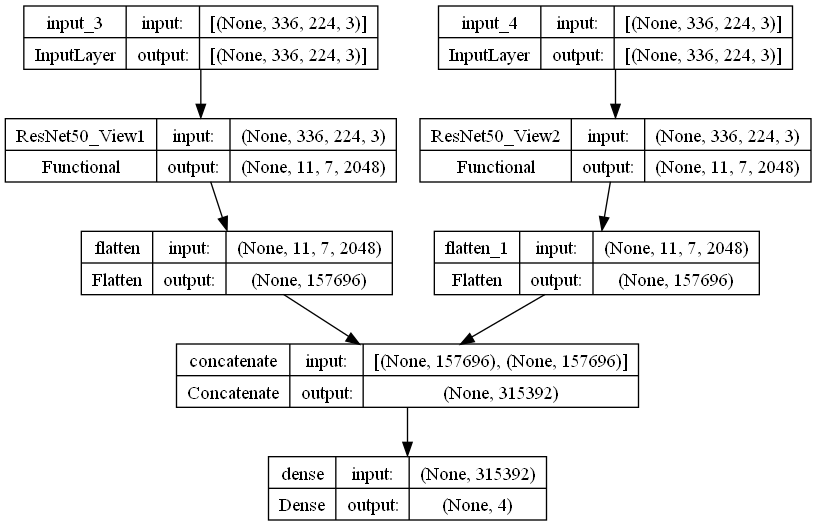

In [3]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

## Load data

In [24]:
import glob 

file_names = glob.glob("experiment-0-preprocessed-mammograms/*.npy")

prefixes = [filename.split('\\')[1].replace(".npy", "") for filename in file_names]

import pandas as pd

def encode_columns(row):
    return row['patient_id'].replace('-', '_') + '.'+row['side']+'_'+row['view']+'.'+'tif'

cases = pd.read_csv('http://127.0.0.1:9000/ddsm/ddsm_description_cases.csv')
cases['minio_path'] = cases.apply(encode_columns, axis=1)
correct_cases = cases[cases['minio_path'].apply(lambda path: path in prefixes)]
correct_cases = correct_cases[correct_cases['breast_density'].apply(lambda instance: instance != 0)]
correct_cases = correct_cases.reset_index()
df = correct_cases[correct_cases["minio_path"].apply(lambda path: "RIGHT" in path)].groupby("patient_id").agg(list)
df['minio_path'] = df['minio_path'].apply(lambda paths: sorted(list(set(paths))))
df = df[df['minio_path'].map(len) >= 2]
df = df.reset_index()
df

,patient_id,index,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
0,A-0243-1,"[2054, 2057]","[2, 2]","[RIGHT, RIGHT]","[MLO, CC]","[nan, nan]","[normals, normals]","[nan, nan]","[3256, 3196]","[5446, 5461]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[A_0243_1.RIGHT_CC.tif, A_0243_1.RIGHT_MLO.tif]"
1,A-0244-1,"[1990, 1992]","[3, 3]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[normals, normals]","[nan, nan]","[1861, 2011]","[3886, 4876]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[A_0244_1.RIGHT_CC.tif, A_0244_1.RIGHT_MLO.tif]"
2,A-0245-1,"[2328, 2329]","[4, 4]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[normals, normals]","[nan, nan]","[2371, 2296]","[4561, 4726]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[A_0245_1.RIGHT_CC.tif, A_0245_1.RIGHT_MLO.tif]"
3,A-0246-1,"[2284, 2285]","[2, 2]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[normals, normals]","[nan, nan]","[2146, 2266]","[4891, 5071]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[A_0246_1.RIGHT_CC.tif, A_0246_1.RIGHT_MLO.tif]"
4,A-0247-1,"[1970, 1973]","[1, 1]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[normals, normals]","[nan, nan]","[2806, 2956]","[5446, 5431]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[A_0247_1.RIGHT_CC.tif, A_0247_1.RIGHT_MLO.tif]"
...,...,...,...,...,...,...,...,...,...,...,...,...
2429,D-4605-1,"[1636, 1637]","[2, 2]","[RIGHT, RIGHT]","[CC, MLO]","[nan, nan]","[normals, normals]","[nan, nan]","[4111, 4801]","[6601, 6586]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[D_4605_1.RIGHT_CC.tif, D_4605_1.RIGHT_MLO.tif]"
2430,D-4606-1,"[1618, 1620]","[2, 2]","[RIGHT, RIGHT]","[MLO, CC]","[nan, nan]","[normals, normals]","[nan, nan]","[3796, 3736]","[6331, 6241]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[D_4606_1.RIGHT_CC.tif, D_4606_1.RIGHT_MLO.tif]"
2431,D-4607-1,"[1667, 1669]","[1, 1]","[RIGHT, RIGHT]","[MLO, CC]","[nan, nan]","[normals, normals]","[nan, nan]","[4426, 4231]","[6541, 6811]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[D_4607_1.RIGHT_CC.tif, D_4607_1.RIGHT_MLO.tif]"
2432,D-4608-1,"[1615, 1617]","[2, 2]","[RIGHT, RIGHT]","[MLO, CC]","[nan, nan]","[normals, normals]","[nan, nan]","[3976, 3961]","[6691, 5941]",[/home/cicese/condaProj/DDSM-ori/cases/process...,"[D_4608_1.RIGHT_CC.tif, D_4608_1.RIGHT_MLO.tif]"


In [ ]:
wrong_cases = cases[cases['patient_id'].apply(lambda patient_id: not correct_cases['patient_id'].isin([patient_id]).any() )]
wrong_cases

,patient_id,breast_density,side,view,assessment,pathology,subtlety,width,height,od_img_path,minio_path
934,A-0121-1,2,LEFT,CC,NaN,normals,NaN,2654,5519,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0121_1.LEFT_CC.tif
935,A-0121-1,2,LEFT,MLO,NaN,normals,NaN,2639,5474,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0121_1.LEFT_MLO.tif
936,A-0121-1,2,RIGHT,MLO,NaN,normals,NaN,2729,5504,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0121_1.RIGHT_MLO.tif
937,A-0121-1,2,RIGHT,CC,NaN,normals,NaN,2804,5474,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0121_1.RIGHT_CC.tif
938,A-0070-1,3,LEFT,MLO,NaN,normals,NaN,2609,5264,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0070_1.LEFT_MLO.tif
...,...,...,...,...,...,...,...,...,...,...,...
2377,A-0223-1,2,RIGHT,CC,NaN,normals,NaN,2176,4516,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_0223_1.RIGHT_CC.tif
8257,A-1825-1,0,LEFT,CC,NaN,cancers,NaN,1816,4501,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_1825_1.LEFT_CC.tif
8258,A-1825-1,0,LEFT,MLO,NaN,cancers,NaN,2671,5491,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_1825_1.LEFT_MLO.tif
8259,A-1825-1,0,RIGHT,CC,NaN,cancers,NaN,1831,4576,/home/cicese/condaProj/DDSM-ori/cases/processe...,A_1825_1.RIGHT_CC.tif


## Data Exploration

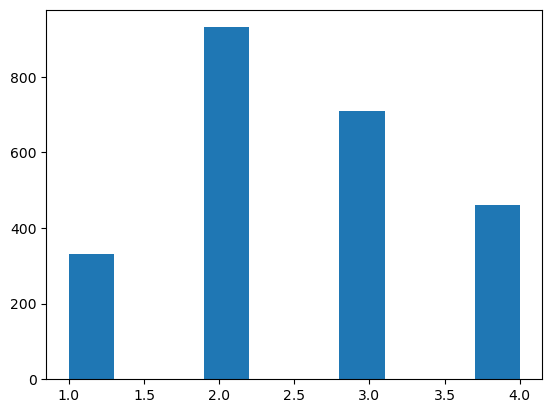

In [7]:
df['breast_density'].apply(lambda instance: instance[0]).hist(grid=False);

In [8]:
density= df['breast_density'].apply(lambda instance: instance[0])
density.groupby(lambda x: density[x]).count()

1    332
2    931
3    710
4    461
Name: breast_density, dtype: int64

# Training

In [93]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [117]:
from sklearn.model_selection import KFold
import os
import datetime
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

def train(loss_fn,number_of_folds=5,epochs=50,batch_size=64):
    k = number_of_folds
    kf = KFold(n_splits=k, shuffle=True)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    fold_no = 1
    for train_index, val_index in kf.split(df):
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        train_dataset = generate_dataset_from_index(train_index).map(lambda inputs, label: ((data_augmentation(inputs[0], training=True),data_augmentation(inputs[1], training=True)), label), num_parallel_calls=AUTOTUNE)
        val_dataset = generate_dataset_from_index(val_index)
        model = create_model(loss_fn)
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs, 
            batch_size=batch_size,
            verbose=1,
            callbacks=[tensorboard_callback]
        )
        fold_no += 1

## Loss function: Mean squared error

In [118]:
train(loss_fn=tf.keras.losses.mean_squared_error)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
61/61 [==============================] - 23s 322ms/step - loss: 6.1709 - accuracy: 0.1834 - val_loss: 6.0289 - val_accuracy: 0.1396
Epoch 2/50
61/61 [==============================] - 19s 306ms/step - loss: 6.1658 - accuracy: 0.1875 - val_loss: 6.0289 - val_accuracy: 0.3922
Epoch 3/50
61/61 [==============================] - 20s 321ms/step - loss: 6.1657 - accuracy: 0.1870 - val_loss: 6.0288 - val_accuracy: 0.3922
Epoch 4/50
61/61 [==============================] - 19s 307ms/step - loss: 6.1632 - accuracy: 0.1870 - val_loss: 6.0132 - val_accuracy: 0.3922
Epoch 5/50
61/61 [==============================] - 19s 303ms/step - loss: 6.1456 - accuracy: 0.2173 - val_loss: 6.0081 - val_accuracy: 0.3922
Epoch 6/50
61/61 [==============================] - 19s 310ms/step - loss: 6.1449 - accuracy: 0.2655 - val_loss: 6.0081 - val_accuracy: 0.2854
Epoch 7/50
61/61 [===========================

## Sum square error loss

In [ ]:
# 

## Focal loss

In [119]:
train(loss_fn=SparseCategoricalFocalLoss(gamma=0.25,reduction=tf.keras.losses.Reduction.NONE))

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
61/61 [==============================] - 23s 315ms/step - loss: nan - accuracy: 0.0067 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/50
61/61 [==============================] - 19s 302ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/50
61/61 [==============================] - 19s 307ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/50
61/61 [==============================] - 19s 304ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/50
61/61 [==============================] - 19s 303ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/50
61/61 [==============================] - 19s 304ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/50
61/61 [===================

## Sparse Weighted cross-entropy loss 

In [122]:
train(loss_fn=sparse_categorical_weighted_cross_entropy_loss)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
61/61 [==============================] - 23s 321ms/step - loss: 0.1117 - accuracy: 0.2209 - val_loss: 0.1090 - val_accuracy: 0.1437
Epoch 2/50
61/61 [==============================] - 20s 318ms/step - loss: 0.1184 - accuracy: 0.2527 - val_loss: 0.1094 - val_accuracy: 0.1437
Epoch 3/50
61/61 [==============================] - 19s 314ms/step - loss: 0.1177 - accuracy: 0.2486 - val_loss: 0.1094 - val_accuracy: 0.1437
Epoch 4/50
61/61 [==============================] - 19s 307ms/step - loss: 0.1177 - accuracy: 0.2486 - val_loss: 0.1094 - val_accuracy: 0.1437
Epoch 5/50
61/61 [==============================] - 19s 303ms/step - loss: 0.1177 - accuracy: 0.2486 - val_loss: 0.1094 - val_accuracy: 0.1437
Epoch 6/50
61/61 [==============================] - 19s 305ms/step - loss: 0.1177 - accuracy: 0.2486 - val_loss: 0.1094 - val_accuracy: 0.1437
Epoch 7/50
61/61 [===========================